In [2]:
# Install dependencies
# DON'T RUN
# !pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from numerapi import NumerAPI
napi = NumerAPI()

import pandas as pd

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

/Users/ismadelic/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ismadelic/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import json

# # download the feature metadata file
# napi.download_dataset(f"{DATA_VERSION}/features.json"); # ONLY RUN ONCE!

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]

small_feature_set = feature_sets["small"]
medium_feature_set = feature_sets["medium"]

# # Download the training data - this will take a few minutes
# napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet"); # ONLY RUN ONCE!

# Load only the "small" and "medium" feature set to
# Use the "all" feature set to use all features
small_data = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + small_feature_set
)
medium_data = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + medium_feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
small_data = small_data[small_data["era"].isin(small_data["era"].unique()[::4])]
medium_data = medium_data[medium_data["era"].isin(medium_data["era"].unique()[::4])]


In [6]:
small_X_train = small_data[small_feature_set]
small_y_train = small_data["target"]
medium_X_train = medium_data[medium_feature_set]
medium_y_train = medium_data["target"]

In [7]:
# find correlation between features and outcome
corr = medium_X_train.corrwith(medium_y_train)
corr.sort_values()

feature_enzymatic_poorest_advocaat             -0.011773
feature_unswaddled_inenarrable_goody           -0.011449
feature_wetter_unbaffled_loma                  -0.007477
feature_floatiest_quintuplicate_carpentering   -0.007150
feature_unbarking_apolitical_hibernian         -0.007114
                                                  ...   
feature_hunchbacked_unturning_meditation        0.010299
feature_denuded_typed_wattmeter                 0.010343
feature_pruinose_raploch_roubaix                0.010585
feature_leaky_overloaded_rhodium                0.011407
feature_simpatico_cadential_pup                 0.012055
Length: 705, dtype: float64

In [8]:
# Find the most correlated features
corr_sorted = abs(corr).sort_values(ascending=False).head()
corr_sorted

feature_simpatico_cadential_pup         0.012055
feature_enzymatic_poorest_advocaat      0.011773
feature_unswaddled_inenarrable_goody    0.011449
feature_leaky_overloaded_rhodium        0.011407
feature_pruinose_raploch_roubaix        0.010585
dtype: float64

In [9]:
# # get 100 most correlated features
# medium100_feature_set = corr.columns # can't get it to work
# medium100_X_train = medium_X_train[medium100_feature_set]

In [10]:
small_y_train = pd.Categorical(small_y_train).codes
medium_y_train = pd.Categorical(medium_y_train).codes

In [11]:
# feature_set_sizes = {'small': [small_X_train,small_y_train], 'medium': [medium_X_train,medium_y_train], 'medium100': [medium100_X_train,medium_y_train]}
feature_set_sizes = {'small': [small_X_train,small_y_train], 'medium': [medium_X_train,medium_y_train]}
kernels = ['linear', 'poly', 'rbf']
lambds = [1.0, 0.1, 0.01, 0.001, 0.0001]
models = {}
train_predictions = {}
train_scores = {}

In [12]:
from sklearn.svm import SVC # "Support vector classifier"

In [13]:
for size, (X_train, y_train) in feature_set_sizes.items():
  for kernel in kernels:
    for lambd in lambds:
      m_name = size+' '+kernel+' '+str(lambd)
      model = SVC(kernel=kernel, C=lambd)
      print("training model: "+m_name)

      model.fit(X_train[:1000], y_train[:1000])
      models[m_name] = model

      prediction = model.predict(X_train[:1000])
      train_predictions[m_name] = prediction

      score = model.score(X_train[:1000], y_train[:1000])
      train_scores[m_name] = score

training model: small linear 1.0
training model: small linear 0.1
training model: small linear 0.01
training model: small linear 0.001
training model: small linear 0.0001
training model: small poly 1.0
training model: small poly 0.1
training model: small poly 0.01
training model: small poly 0.001
training model: small poly 0.0001
training model: small rbf 1.0
training model: small rbf 0.1
training model: small rbf 0.01
training model: small rbf 0.001
training model: small rbf 0.0001
training model: medium linear 1.0
training model: medium linear 0.1
training model: medium linear 0.01
training model: medium linear 0.001
training model: medium linear 0.0001
training model: medium poly 1.0
training model: medium poly 0.1
training model: medium poly 0.01
training model: medium poly 0.001
training model: medium poly 0.0001
training model: medium rbf 1.0
training model: medium rbf 0.1
training model: medium rbf 0.01
training model: medium rbf 0.001
training model: medium rbf 0.0001


In [14]:
best_small_models = ['small poly 1.0']
best_medium_models = []
for name,score in train_scores.items():
  if score>0.7 and name.split(' ')[0] =='medium':
    best_medium_models.append(name)
    print(name+':', score)

medium linear 1.0: 1.0
medium linear 0.1: 0.943
medium linear 0.01: 0.799
medium poly 1.0: 1.0
medium poly 0.1: 0.859


small poly 1.0: 0.838\
medium linear 1.0: 1.0\
medium linear 0.1: 0.943\
medium linear 0.01: 0.799\
medium poly 1.0: 1.0\
medium poly 0.1: 0.859


In [15]:
# Download validation data - this will take a few minutes
# napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet"); # ONLY RUN ONCE!

# Load the validation data and filter for data_type == "validation"
small_validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + small_feature_set
)
medium_validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + medium_feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
small_validation = small_validation[small_validation["era"].isin(small_validation["era"].unique()[::4])]
medium_validation = medium_validation[medium_validation["era"].isin(medium_validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(small_data["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
small_validation = small_validation[~small_validation["era"].isin(eras_to_embargo)]
medium_validation = medium_validation[~medium_validation["era"].isin(eras_to_embargo)]

# # Generate predictions against the out-of-sample validation features
# # This will take a few minutes 🍵
# small_validation["prediction"] = model.predict(small_validation[small_feature_set])
# medium_validation["prediction"] = model.predict(medium_validation[medium_feature_set])
# small_validation[["era", "prediction", "target"]]
# medium_validation[["era", "prediction", "target"]]

In [16]:
# For splitting val into test and val sets, may be unnecessary
# small_X_val, small_X_test, small_y_val, small_y_test = train_test_split(
#     small_validation[small_feature_set], small_validation["target"],
#     test_size = 0.1, random_state=10, shuffle=True
# )
# medium_X_val, medium_X_test, medium_y_val, medium_y_test = train_test_split(
#     medium_validation[medium_feature_set], medium_validation["target"],
#     test_size = 0.1, random_state=10, shuffle=True
# )

small_X_val = small_validation[small_feature_set]
small_y_val = small_validation['target']
medium_X_val = medium_validation[medium_feature_set]
medium_y_val = medium_validation['target']

small_y_val = pd.Categorical(small_y_val).codes
medium_y_val = pd.Categorical(medium_y_val).codes

In [17]:
val_predictions = {}
val_scores = {}

# predict for best small models
for m_name in best_small_models:
  model = models[m_name]
  prediction = model.predict(small_X_val[:1000])
  val_predictions[m_name] = prediction

  score = model.score(small_X_val[:1000], small_y_val[:1000])
  val_scores[m_name] = score

In [18]:
# predict for best medium models
for m_name in best_medium_models:
    model = models[m_name]
    prediction = model.predict(medium_X_val[:1000])
    val_predictions[m_name] = prediction

    score = model.score(medium_X_val[:1000], medium_y_val[:1000])
    val_scores[m_name] = score


In [19]:
for name,score in val_scores.items():
  print(name+':', score)

small poly 1.0: 0.355
medium linear 1.0: 0.311
medium linear 0.1: 0.336
medium linear 0.01: 0.402
medium poly 1.0: 0.416
medium poly 0.1: 0.49


In [20]:
best_m_name = 'medium poly 0.1'

In [22]:
# Retrain the best chosen model using entire data, this might take a while
best_model = SVC(kernel='poly', C=0.1)

best_model.fit(medium_X_train[:10000], medium_y_train[:10000])

In [23]:
val_prediction = best_model.predict(medium_X_val[:10000])
val_score = best_model.score(medium_X_val[:10000], medium_y_val[:10000])

In [25]:
print("validation score: " + str(val_score))

validation score: 0.4837


Below are some helpful visualizations

In [ ]:
# Plot accuracy for each model on the training and validation set (X-axis: model, y-axis: accuracy score)

Text(0, 0.5, 'Training Accuracy')

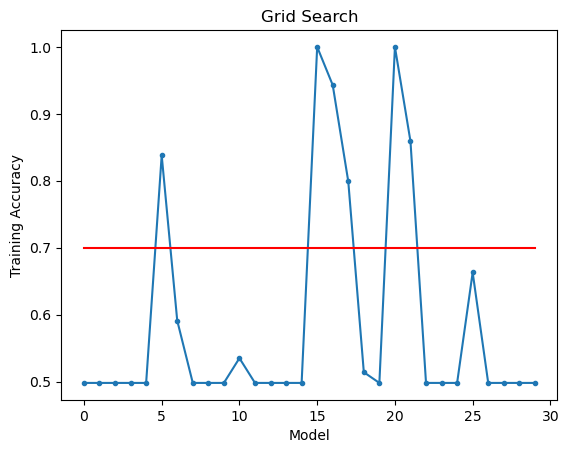

In [29]:
# training error
plt.plot(range(len(train_scores.keys())),train_scores.values(),marker='.')
plt.plot(range(len(train_scores.keys())), np.repeat(0.7, len(train_scores.keys())), color='r')
plt.title('Grid Search')
plt.xlabel('Model')
plt.ylabel('Training Accuracy')

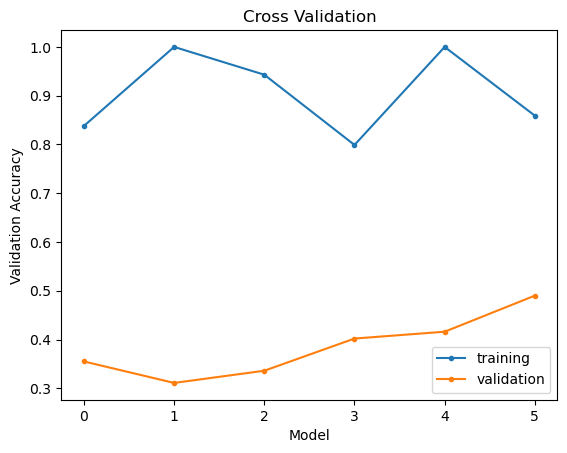

In [28]:
# val error
best_train_scores = [0.838, 1.0,0.943,0.799,1.0,0.859]
plt.plot(range(len(best_train_scores)),best_train_scores,marker='.', label='training')
plt.plot(range(len(val_scores.keys())),val_scores.values(),marker='.', label='validation')
plt.title('Cross Validation')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.legend()